In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

In [27]:
data=pd.read_csv('data/wb_dataset.txt', sep='\t',header=0)
data

,Time,Time Code,Country Name,Country Code,"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%) [SH.DYN.NCOM.ZS]",Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS],Current health expenditure per capita (current US$) [SH.XPD.CHEX.PC.CD],Out-of-pocket expenditure (% of current health expenditure) [SH.XPD.OOPC.CH.ZS],GDP (current US$) [NY.GDP.MKTP.CD],GDP per capita (current US$) [NY.GDP.PCAP.CD],Human capital index (HCI) (scale 0-1) [HD.HCI.OVRL]
0,2018,YR2018,Afghanistan,AFG,35.4,9.39572716,49.84260941,78.38278198,18053228578.8878,485.668418729808,0.393489241600037
1,2018,YR2018,Albania,ALB,11.8,5.26271439,274.91409302,44.58411789,15156432309.8977,5287.66369446913,0.628666281700134
2,2018,YR2018,Algeria,DZA,13.9,6.2184267,255.86943054,32.64655304,174910878623.049,4142.01855842917,0.531993925571442
3,2018,YR2018,American Samoa,ASM,..,..,..,..,639000000,11521.6097798453,..
4,2018,YR2018,Andorra,AND,..,6.71033096,2821.80126953,13.58695602,3218316013.22626,41791.9698372411,..
...,...,...,...,...,...,...,...,...,...,...,...
266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,Data from database: World Development Indicators,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Mortalité par cancer en fonction des dépenses en santé du pays, des dépenses directes de chaque citoyen en santé, du PIB et de l'indice de capital humain (World Bank Indice)

Attribute selection
===================

* Remove attributes containing many missing values.

* Remove attributes that seem redundant because of strong correlations.

* Used derived attributes to exhibit variables that could be more pertinent (relative value, ratio, difference, relative variation, indicator combining several attributes, ...).

* Choose a subset of the dimensions to focus on some aspects and/or to simplify the interpretations. For methods that use distances, reduce the number of dimensions between 4 and 6, and standardize the data if necessary.

Remark: It is possible to complete the dataset with other sources.

In [4]:
#Renaming attribute for easier use
# Time = removed
# Time Code = removed
# Country Name = country_name
# Country Code = country_code
# Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%) = mortality
# Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS] = health_cost_percent
# Current health expenditure per capita (current US$) [SH.XPD.CHEX.PC.CD] = health_cost_capita_percent
# Out-of-pocket expenditure (% of current health expenditure) [SH.XPD.OOPC.CH.ZS] = health_oop_cost
# GDP (current US$) [NY.GDP.MKTP.CD] = gdp
# GDP per capita (current US$) [NY.GDP.PCAP.CD] = gdp_capita
# Human capital index (HCI) (scale 0-1) [HD.HCI.OVRL] hci

In [28]:
#Drop the 2 first column (time and time code)
data.drop(["Time","Time Code"], axis=1, inplace=True)
# Remove the last 5 lines that are now empty
data.drop(data.tail(5).index,inplace=True)

In [29]:
data.columns = ['country_name','country_code','mortality','health_cost_percent','health_cost_capita_percent','health_oop_cost','gdp','gdp_capita','hci']
data

,country_name,country_code,mortality,health_cost_percent,health_cost_capita_percent,health_oop_cost,gdp,gdp_capita,hci
0,Afghanistan,AFG,35.4,9.39572716,49.84260941,78.38278198,18053228578.8878,485.668418729808,0.393489241600037
1,Albania,ALB,11.8,5.26271439,274.91409302,44.58411789,15156432309.8977,5287.66369446913,0.628666281700134
2,Algeria,DZA,13.9,6.2184267,255.86943054,32.64655304,174910878623.049,4142.01855842917,0.531993925571442
3,American Samoa,ASM,..,..,..,..,639000000,11521.6097798453,..
4,Andorra,AND,..,6.71033096,2821.80126953,13.58695602,3218316013.22626,41791.9698372411,..
...,...,...,...,...,...,...,...,...,...
261,Sub-Saharan Africa,SSF,21.5982120151935,5.15768660576918,83.2490352335023,33.3422917546122,1753414899266.08,1626.06247939811,..
262,Sub-Saharan Africa (excluding high income),SSA,21.5983081283383,5.15772866878292,83.1807940240755,33.3512591470402,1751867208506.64,1624.7729965878,..
263,Sub-Saharan Africa (IDA & IBRD countries),TSS,21.5982120151935,5.15768660576918,83.2490352335023,33.3422917546123,1753414899266.08,1626.06247939811,..
264,Upper middle income,UMC,16.8513728002943,5.82358644218712,532.032141629768,32.8682192051733,23638682947940,9468.93298334383,..


In [30]:
hcp=pd.to_numeric(data[data["health_cost_percent"]!=".."]["health_cost_percent"],downcast='float')
hccp=pd.to_numeric(data[data["health_cost_capita_percent"]!=".."]["health_cost_capita_percent"],downcast='float')
np.corrcoef(hcp,hccp) #il semble y avoir une corrélation entre health_cost_percent et health_cost_capita_percent
#On choisit donc de supprimer la variable health_cost_capita_percent      ###Si tu confirmes mdrr

array([[1.        , 0.56630917],
       [0.56630917, 1.        ]])

In [31]:
gdp = pd.to_numeric(data[data["gdp"]!=".."]["gdp"],downcast='float')
gdpc = pd.to_numeric(data[data["gdp_capita"]!=".."]["gdp_capita"],downcast='float')
np.corrcoef(gdp,gdpc) #il ne semble pas y avoir une corrélation très importante entre gdp et gdp_capita

array([[1.        , 0.05888461],
       [0.05888461, 1.        ]])

Object selection
================

* Remove objects containing missing values (except if using methods that handle clearly the missing values).

* Identified the outliers (exceptional objects, noise, ...) in 1D, 2D, n-dimensions. Keep track of them and eventually remove them.


In [32]:
#We remove the region object because they are already agregate of data which we are not interested into
count_removed_region = len(data) - data.index[data['country_code'] == "ZWE"][0] - 1
if count_removed_region > 0 :
    data.drop(data.tail(count_removed_region).index,inplace=True)
    
print(count_removed_region)

49


In [33]:
#We remove the object where we have no data about cancers mortality
count_removed_nodata = len(data.loc[data['mortality'] == ".."])
if (count_removed_nodata > 0):
    data.drop(data.index[data['mortality'] == ".."],inplace=True)

print(count_removed_nodata)

34


In [34]:
#We choose to remove the object where more than 1 of the selected attributes are missing
missing_attributes = pd.DataFrame(data.apply(pd.Series.value_counts, axis=1)[".."])
missing_attributes_index = missing_attributes.index[missing_attributes[".."] > 1]
if (len(missing_attributes_index)>0):
    data.drop(missing_attributes_index,inplace=True)
print(len(missing_attributes_index))
data

8


,country_name,country_code,mortality,health_cost_percent,health_cost_capita_percent,health_oop_cost,gdp,gdp_capita,hci
0,Afghanistan,AFG,35.4,9.39572716,49.84260941,78.38278198,18053228578.8878,485.668418729808,0.393489241600037
1,Albania,ALB,11.8,5.26271439,274.91409302,44.58411789,15156432309.8977,5287.66369446913,0.628666281700134
2,Algeria,DZA,13.9,6.2184267,255.86943054,32.64655304,174910878623.049,4142.01855842917,0.531993925571442
5,Angola,AGO,22.1,2.54900527,87.61676788,36.79880905,101353230784.594,3289.64399476678,0.360190957784653
6,Antigua and Barbuda,ATG,17.7,5.23155928,875.17254639,29.45855904,1605944444.44444,16679.5916624545,0.578216969966888
...,...,...,...,...,...,...,...,...,...
208,Uzbekistan,UZB,25.9,5.29149055,82.26926422,60.34236145,52633143808.1824,1597.0683366109,..
209,Vanuatu,VUT,39.8,3.37372637,105.3915863,8.99114323,914727908.137793,3125.40499918952,0.444750398397446
211,Vietnam,VNM,21.4,5.91789675,151.68611145,44.90139008,245213686369.157,2566.4474870063,0.687239348888397
215,Zambia,ZMB,25.6,4.93484306,75.99179077,9.98299885,26311590296.7021,1516.36837125728,0.39117556810379


In [ ]:
pd.to_numeric(data[data["mortality"] != ".."][nomColonne], downcast='float')

In [ ]:
#Looking to the outliers


Clustering
==========

* Look for clusters of globular shapes and of arbitrary shapes, using in particular K-means, hierarchical complete/single and DBSCAN.

* Compute dendrograms for hierarchical clustering.

* Determine good candidates for the number of clusters (using SSE, silhouette coefficient and grouping distance curves).

* Study the stability of the K-means convergence.

* Compare (using entropy or mutual entropy, and contingency tables) the content of the clusters to a known labelling or to the result of another clustering.

* Describe the envelope (the borders) of the clusters using a decision tree (on a dataset having at least 4 dimensions).


Remarks:

- Removing outliers can improve the stability and the dispersion.

- Clustering evaluation can be made by comparing SSE and silhouette coefficient obtain of the data to their values on random dataset or on partially randomize data.

In [37]:
#We choose to remove the object where at least 1 of the selected attributes are missing    ### tu valides? (sinon ça met une erreur dans le clustering)
missing_attributes = pd.DataFrame(data.apply(pd.Series.value_counts, axis=1)[".."])
missing_attributes_index = missing_attributes.index[missing_attributes[".."] > 0]
if (len(missing_attributes_index)>0):
    data.drop(missing_attributes_index,inplace=True)
print(len(missing_attributes_index))
data

19


,country_name,country_code,mortality,health_cost_percent,health_cost_capita_percent,health_oop_cost,gdp,gdp_capita,hci
0,Afghanistan,AFG,35.4,9.39572716,49.84260941,78.38278198,18053228578.8878,485.668418729808,0.393489241600037
1,Albania,ALB,11.8,5.26271439,274.91409302,44.58411789,15156432309.8977,5287.66369446913,0.628666281700134
2,Algeria,DZA,13.9,6.2184267,255.86943054,32.64655304,174910878623.049,4142.01855842917,0.531993925571442
5,Angola,AGO,22.1,2.54900527,87.61676788,36.79880905,101353230784.594,3289.64399476678,0.360190957784653
6,Antigua and Barbuda,ATG,17.7,5.23155928,875.17254639,29.45855904,1605944444.44444,16679.5916624545,0.578216969966888
...,...,...,...,...,...,...,...,...,...
207,Uruguay,URY,16.9,9.20269966,1590.04821777,16.9604454,64515038268.1373,18703.8602924478,0.602367758750916
209,Vanuatu,VUT,39.8,3.37372637,105.3915863,8.99114323,914727908.137793,3125.40499918952,0.444750398397446
211,Vietnam,VNM,21.4,5.91789675,151.68611145,44.90139008,245213686369.157,2566.4474870063,0.687239348888397
215,Zambia,ZMB,25.6,4.93484306,75.99179077,9.98299885,26311590296.7021,1516.36837125728,0.39117556810379


In [42]:
objects_=data.drop(['country_name'],axis=1)
objects=objects_.drop(['country_code'],axis=1)
km=KMeans() # create a KMeans object (n_clusters=8 par défaut)
km.fit(objects) # compute the clusters
centroids=km.cluster_centers_ # get the cluster centers
print(centroids)

[[2.20638095e+01 6.03788691e+00 5.26731211e+02 3.49247760e+01
  3.75122067e+10 8.68723555e+03 5.15506245e-01]
 [1.36000000e+01 1.68852978e+01 1.06238496e+04 1.08088608e+01
  2.06118609e+13 6.30644184e+04 7.13683248e-01]
 [1.22714286e+01 8.58757074e+00 2.87796827e+03 2.52165594e+01
  1.70867174e+12 3.17788884e+04 7.39882852e-01]
 [1.60000000e+01 5.35107994e+00 5.01059387e+02 3.57506561e+01
  1.38948175e+13 9.90534200e+03 6.47098839e-01]
 [1.03000000e+01 1.11916695e+01 4.86939453e+03 1.26985765e+01
  4.50611949e+12 4.38791747e+04 8.02240998e-01]
 [1.54000000e+01 6.92316564e+00 2.12574373e+03 2.97416481e+01
  3.52335721e+11 2.60344394e+04 6.54102786e-01]
 [1.44000000e+01 8.26636736e+00 3.02611151e+03 2.95412680e+01
  2.79716573e+12 2.90721174e+04 6.72579447e-01]
 [1.60333333e+01 6.76307968e+00 2.94715684e+03 2.45932260e+01
  9.13134976e+11 3.09632075e+04 6.54137244e-01]]


In [43]:
clusters = km.labels_ # get cluster labels for all objects

In [ ]:
#on peut peut-être faire des ptits graphiques avec sns.scatterplot

Hierarchical aggregation :

In [45]:
import scipy.cluster.hierarchy as sch
Z = sch.linkage(objects, method='complete', metric='euclidean')
Z[:5]

array([[1.28000000e+02, 1.40000000e+02, 9.27701743e+06, 2.00000000e+00],
       [1.19000000e+02, 1.33000000e+02, 9.98692804e+06, 2.00000000e+00],
       [2.90000000e+01, 9.70000000e+01, 1.20252536e+07, 2.00000000e+00],
       [8.60000000e+01, 9.50000000e+01, 1.88429638e+07, 2.00000000e+00],
       [2.70000000e+01, 5.10000000e+01, 2.22740212e+07, 2.00000000e+00]])

Dendrogram for hierarchical clustering :

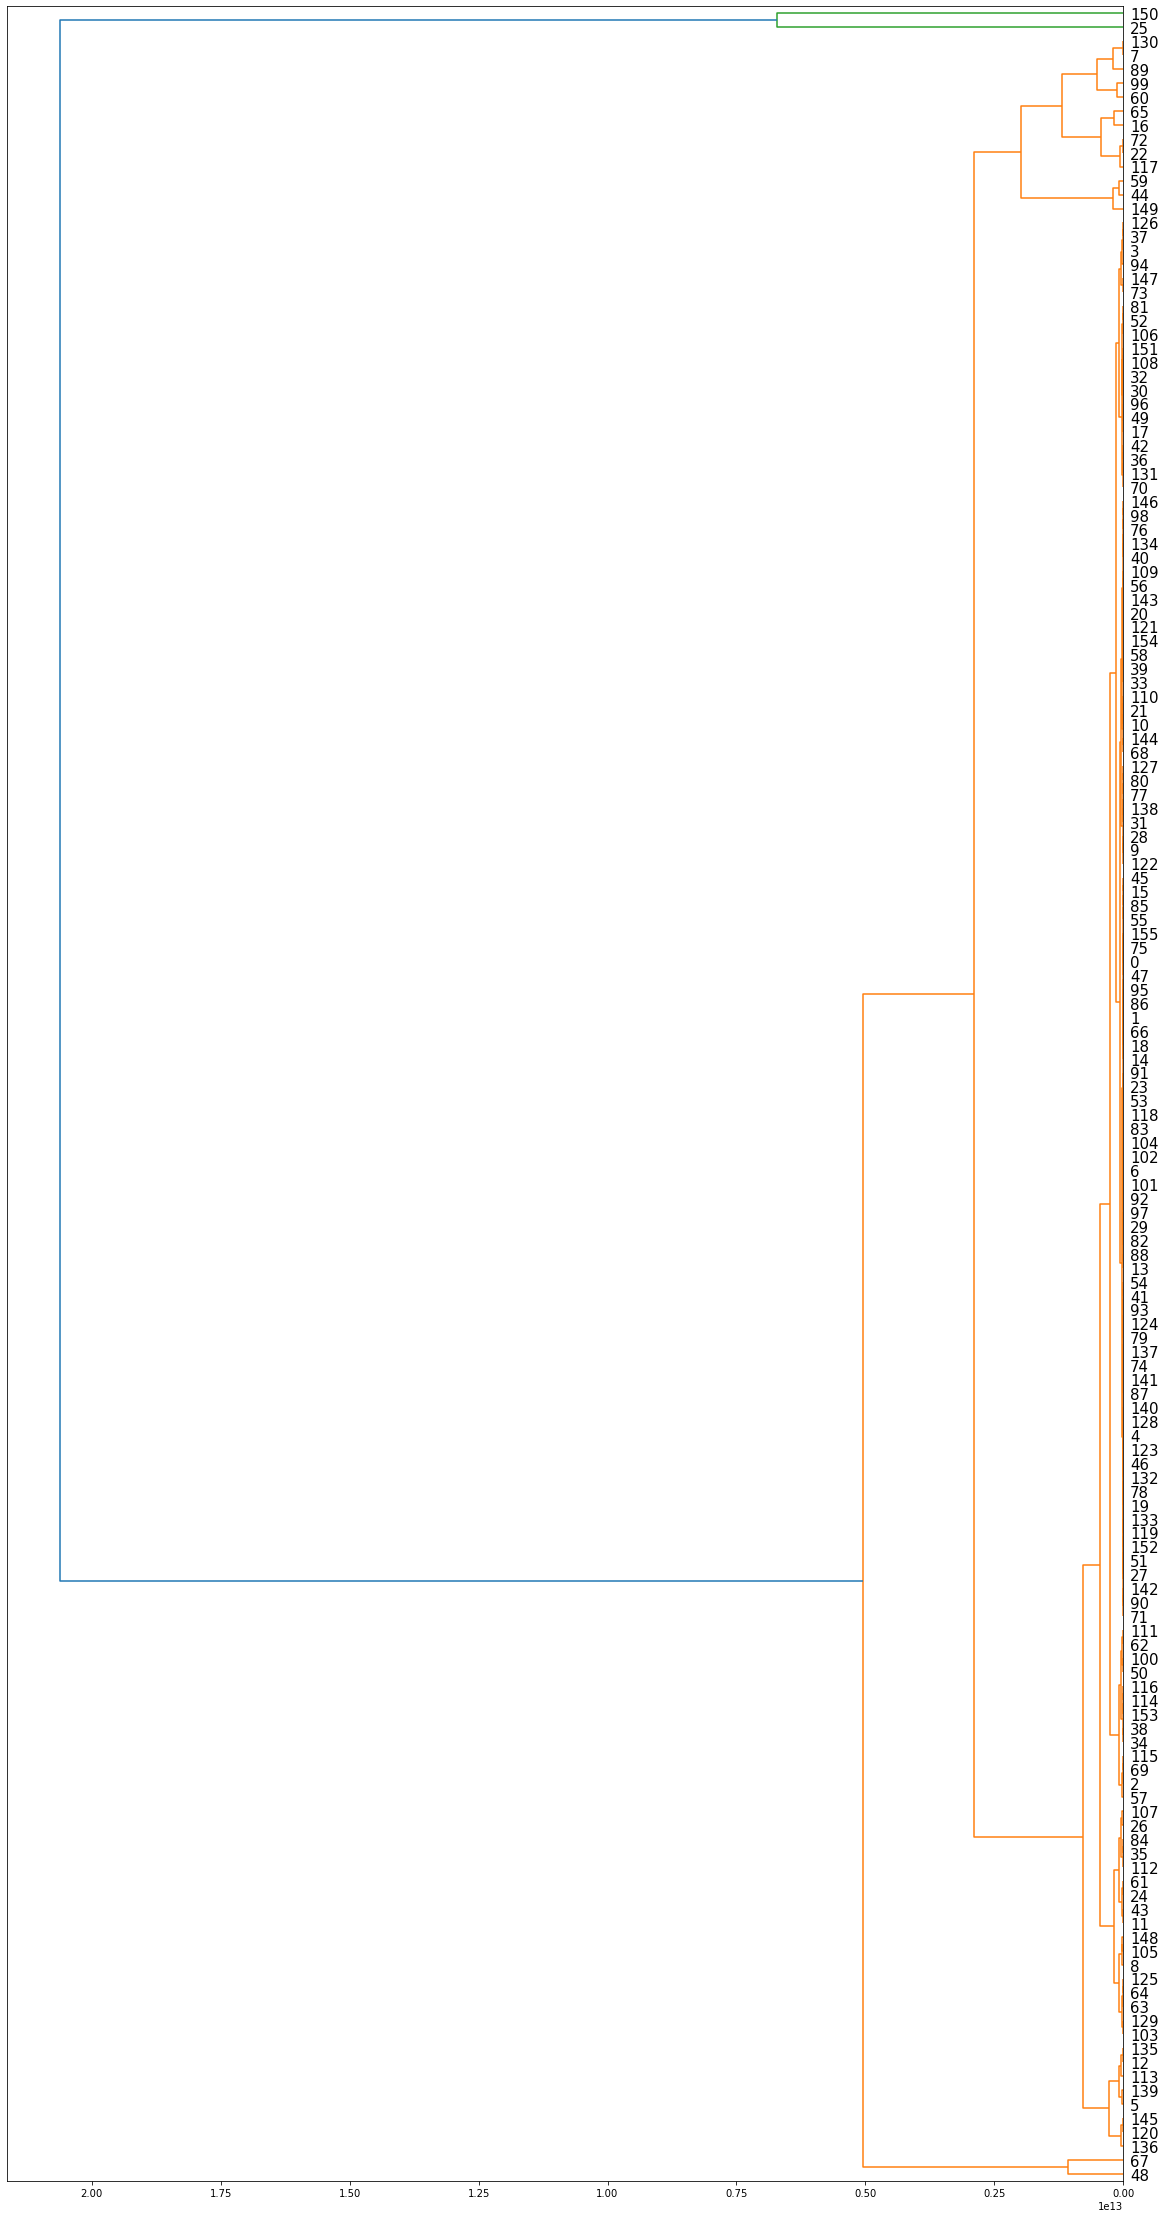

In [46]:
fig = plt.figure(figsize=(20, 40))
dendro = sch.dendrogram(Z, orientation='left', leaf_rotation=0, leaf_font_size=15)

Determine good candidates for the number of clusters (using SSE, silhouette coefficient and grouping distance curves)

In [47]:
sse = km.inertia_
print("sse = ",sse)

sse =  1.663653148665245e+24


In [48]:
# Get SSE when varying the number of clusters
sse_list = []
k_list = range(2,11)
for i in k_list:
    km_i_clusters=KMeans(n_clusters=i)
    km_i_clusters.fit(objects)
    sse_list = sse_list + [km_i_clusters.inertia_]
print(sse_list)

[1.0169912700836761e+26, 4.297219334998264e+25, 2.0412857434550986e+25, 9.56644276418915e+24, 5.499745466083854e+24, 2.72330427986201e+24, 1.663653148665245e+24, 1.1002147825139967e+24, 7.356972117946094e+23]


Text(0, 0.5, 'SSE')

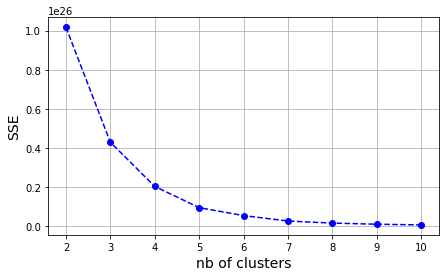

In [49]:
fig = plt.figure(figsize=(7, 4))
plt.plot(k_list,sse_list,'bo--')
plt.grid()
plt.xlabel("nb of clusters",fontsize=14)
plt.ylabel("SSE",fontsize=14)

Je sais pas trop comment on interprète ce truc mais je dirais que 4 clusters (ou 5) c'est pas mal mdrr

Classification
==============

* Construct a label by discretisation of an attribute (this label can be built by clustering the values of this attribute). Use this label as class label.

* Compare the results obtained using decision trees and the K nearest neighbors.

* Evaluate the quality of the model using cross validation. Report the score for each subset and the global score.

* Modify the learning parameters to detect of possible overfitting.


Remarks:

- A contingency table can be use to analyse the errors by class.

- Removing outliers can reduce error.

- A classification model can be use to predict labels of a targeted attribute for objects where this attribute value is missing.


Report content and format
=========================

* Keep track of the choices made and justify them.

* Give commands and parameters so that the results can be reproduced.

* Show in tables some views of subsets of the data, but not the complete view of all objects in the data. Give the attributes and their units, as well as the number of objects used.

* Give results (values, graphics,...).

* Try to interpret the results in the domain.


Remarks:

- It is possible to study several subsets of attributes (e.g., one for the clustering part, another for the classification tasks).

- The report can suggest directions for future works, e.g., directions that have not been explored due to time constraints.

- The document can be split in two reports: one for the clustering and one for the classification tasks.


How to edit the report
======================

A way to prepare the report is to add "Markdows" cells in the Jupyter notebook to insert text, and use #, ##, ###, #### for headings (section, subsection, subsubsection, paragraph). Next, to get a latex version of the notebook use: "File -> Download as -> LaTeX" (this requires Pandoc to be installed https://pandoc.org/installing.html). And then edit the .tex if needed (to add a title page, to clean some parts, ...), before compiling it.

IMPORTANT 1: the end of long lines in cells containing python commands can be suppressed (due to the latex verbatim mode), to avoid this use lines of at most 80 characters and use "\" to continue the command on the next line.

IMPORTANT 2: if using "File -> print preview" to generate a pdf of the notebook, then the sections will not be numbered, and check also that there is no missing part in long lines.

IMPORTANT 3: "File -> Download as -> LaTeX" may not work for the graphical representation of decision trees, depending on the version of sklearn and on external installed softwares. A workaround is to generate the pdf of the tree and then to include the pdf by a latex command.
Example, with a cell containing the code:
graph = graphviz.Source(dot_data)
graph # to display the tree

replace the cell content by:
graph = graphviz.Source(dot_data)
graph.render("out_iris_decision_tree") # to generate a pdf file

then just below this cell add a Markdown cell containing the following tree lines:
\begin{center}
\adjustimage{max size={0.9\linewidth}{0.9\paperheight}}{out_iris_decision_tree.pdf}
\end{center}

then generate the latex file with "File -> Download as -> LaTeX", put the file out_iris_decision_tree.pdf in the folder of the latex file, and compile the latex file.

---

Zip file to be send by mail
===========================
(mail to Christophe.Rigotti@insa-lyon.fr and Sergio.Peignier@insa-lyon.fr)

Prepare a single folder with name the names of the authors (in lexicographic order): NAME1_NAME2. Zip this folder and send the file NAME1_NAME2.zip

The folder must contains:

- zip file(s) of the data file(s), (txt format to reproduce the work). 

- file(s), (txt format or pdf) containing the definitions of the variables given by the data provider.

- the Jupyter notebook(s) (format .ipynb to reproduce the work).

- the report in one or two pdf files.

